In [1]:
# Main libs
import random
import keras
import tensorflow as tf
from tensorflow import keras

# Data Imports
import os
import numpy as np
import pandas as pd
from glob import glob
import tensorflow.data as tfd
from osgeo import gdal 

# Data Visualization
from PIL import Image
import plotly.express as px
import matplotlib.pyplot as plt
from IPython.display import Image as GIF

# Model
from keras import Sequential
from keras.layers import Conv2D, MaxPool2D, Dropout, BatchNormalization, Input, Conv2DTranspose, concatenate, GlobalAveragePooling2D, Dense
from keras.callbacks import EarlyStopping, ModelCheckpoint

# Ignore Warnings
import warnings
warnings.filterwarnings("ignore")

2025-04-12 10:35:22.177554: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1744454122.496155      31 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1744454122.583344      31 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [ ]:
import random
import keras
import tensorflow as tf
import os
import numpy as np
import pandas as pd
from osgeo import gdal
import plotly
import matplotlib

# Print versions
print(f"keras: {keras.__version__}")
print(f"tensorflow: {tf.__version__}")
print(f"numpy: {np.__version__}")
print(f"pandas: {pd.__version__}")
print(f"gdal: {gdal.__version__}")
print(f"plotly: {plotly.__version__}")
print(f"matplotlib: {matplotlib.__version__}")

In [ ]:
# Data Configs
BATCH_SIZE = 32
IMAGE_SIZE = (128, 128) # OG (512, 512, 3)
IMAGE_DIR = "/kaggle/input/whu-building-dataset/WHU/train/Image"
MASK_DIR = "/kaggle/input/whu-building-dataset/WHU/train/Mask"
PROGRESS_DIR = "./ModelProgress"
if not os.path.exists(PROGRESS_DIR):
    os.mkdir(PROGRESS_DIR)

# Reproducibility
SEED = 42
VALIDATION_SIZE = 32
AUTOTUNE = tfd.AUTOTUNE
tf.random.set_seed(SEED)

In [ ]:
def decode_image(file_path):
    image = tf.io.read_file(file_path)
    image = tf.image.decode_jpeg(image, channels=3)
    image = tf.image.convert_image_dtype(image, tf.float32)
    image = tf.image.resize(image, IMAGE_SIZE)
    return image

def decode_mask(file_path):
    mask = tf.io.read_file(file_path)
    mask = tf.image.decode_png(mask, channels=1)
    mask = tf.image.convert_image_dtype(mask, tf.float32)
    mask = tf.image.resize(mask, IMAGE_SIZE, method=tf.image.ResizeMethod.NEAREST_NEIGHBOR)
    return mask
def show_image(image, alpha=1, cmap=None, title=None):
    if image.shape[-1]==3:
        plt.imshow(image, alpha=alpha)
    else:
        plt.imshow(image, alpha=alpha, cmap=cmap)
    plt.title(title)
    plt.axis('off')
    
def show_image_masks(dataset, n_rows=5, n_cols=3, figsize=(10, 15)):
    images, masks = next(iter(dataset.take(1)))

    plt.figure(figsize=figsize)
    for i in range(1, (n_rows * n_cols) + 1, n_cols):

        plt.subplot(n_rows, n_cols, i)
        show_image(images[i], title="Aerial Imagery")

        plt.subplot(n_rows, n_cols, i + 1)
        show_image(masks[i], title="Image Mask")

        plt.subplot(n_rows, n_cols, i + 2)
        show_image(images[i])
        show_image(masks[i], alpha=0.5, title="Overlapping")

    plt.show()

In [ ]:
# Collect the Image & Mask Paths
train_image_paths = sorted(glob(IMAGE_DIR + "/*"))[:1000]
train_mask_paths = [path.replace("Image", "Mask") for path in train_image_paths]

# Create datasets for images and masks
image_files = tf.data.Dataset.from_tensor_slices(train_image_paths)
mask_files = tf.data.Dataset.from_tensor_slices(train_mask_paths)

del train_image_paths
del train_mask_paths

# Map decode functions
images = image_files.map(decode_image, num_parallel_calls=AUTOTUNE)
masks = mask_files.map(decode_mask, num_parallel_calls=AUTOTUNE)

del image_files
del mask_files

# Combine into a single dataset
dataset = tf.data.Dataset.zip((images, masks))
dataset = dataset.shuffle(1000).batch(BATCH_SIZE).prefetch(AUTOTUNE)

del images
del masks

In [ ]:
# Split into training and validation sets
valid_ds = dataset.take(VALIDATION_SIZE // BATCH_SIZE)  # First part for validation
train_ds = dataset.skip(VALIDATION_SIZE // BATCH_SIZE)  # Remaining part for training

In [ ]:
import tensorflow as tf
from tensorflow import keras
from keras.models import Model
from keras.layers import Conv2D, Conv2DTranspose, Dropout, concatenate, Input
from keras.applications import MobileNetV2
from tensorflow.keras.metrics import Precision, Recall, BinaryAccuracy

# -----------------------------
# Custom F1 Score Metric
# -----------------------------
class F1Score(keras.metrics.Metric):
    def __init__(self, name='f1_score', **kwargs):
        super(F1Score, self).__init__(name=name, **kwargs)
        self.precision = Precision()
        self.recall = Recall()

    def update_state(self, y_true, y_pred, sample_weight=None):
        y_pred = tf.cast(y_pred > 0.5, tf.float32)
        self.precision.update_state(y_true, y_pred, sample_weight)
        self.recall.update_state(y_true, y_pred, sample_weight)

    def result(self):
        p = self.precision.result()
        r = self.recall.result()
        return 2 * ((p * r) / (p + r + tf.keras.backend.epsilon()))

    def reset_states(self):
        self.precision.reset_states()
        self.recall.reset_states()

# -----------------------------
# Decoder Block
# -----------------------------
class DecoderBlock(keras.layers.Layer):
    def __init__(self, filters, rate=None, axis=-1, **kwargs):
        super(DecoderBlock, self).__init__(**kwargs)
        self.filters = filters
        self.rate = rate
        self.axis = axis
        self.convT = Conv2DTranspose(filters, 3, strides=2, padding='same')
        self.conv1 = Conv2D(filters, 3, activation='relu', kernel_initializer='he_normal', padding='same')
        if rate is not None:
            self.drop = Dropout(rate)
        self.conv2 = Conv2D(filters, 3, activation='relu', kernel_initializer='he_normal', padding='same')

    def call(self, inputs):
        x, skip = inputs
        x = self.convT(x)
        x = concatenate([x, skip], axis=self.axis)
        x = self.conv1(x)
        if self.rate is not None:
            x = self.drop(x)
        return self.conv2(x)

# -----------------------------
# U-Net with MobileNetV2 Encoder
# -----------------------------
def build_mobilenet_unet(input_shape=(128, 128, 3)):
    base_model = MobileNetV2(input_shape=input_shape, include_top=False, weights='imagenet')

    # Optional: Freeze encoder weights
    # for layer in base_model.layers:
    #     layer.trainable = False

    # Extract layers for skip connections
    skip_layer_names = [
        'block_1_expand_relu',   # 64x64
        'block_3_expand_relu',   # 32x32
        'block_6_expand_relu',   # 16x16
        'block_13_expand_relu',  # 8x8
    ]
    encoder_output = base_model.get_layer('block_16_project').output  # 4x4

    skips = [base_model.get_layer(name).output for name in skip_layer_names]

    # Decoder
    x = encoder_output
    x = DecoderBlock(512)([x, skips[-1]])   # 4x4 -> 8x8
    x = DecoderBlock(256)([x, skips[-2]])   # 8x8 -> 16x16
    x = DecoderBlock(128)([x, skips[-3]])   # 16x16 -> 32x32
    x = DecoderBlock(64)([x, skips[-4]])    # 32x32 -> 64x64

    x = Conv2DTranspose(32, 3, strides=2, padding='same', activation='relu')(x)  # 64x64 -> 128x128
    outputs = Conv2D(1, 1, activation='sigmoid')(x)  # Binary segmentation output

    return Model(inputs=base_model.input, outputs=outputs, name="MobileNetV2-UNet")

# -----------------------------
# Compile the Model
# -----------------------------
IMAGE_SIZE = (128, 128)
unet = build_mobilenet_unet(input_shape=(*IMAGE_SIZE, 3))

unet.compile(
    loss='binary_crossentropy',
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
    metrics=[
        BinaryAccuracy(name='accuracy'),
        Precision(name='precision'),
        Recall(name='recall'),
        F1Score(name='f1_score')
    ]
)

# -----------------------------
# Model Summary
# -----------------------------
unet.summary()


In [ ]:
# Assuming you have your `dataset`, `IMAGE_SIZE`, `BATCH_SIZE`, and `VALIDATION_SIZE` defined.

# Split into train and validation sets
valid_ds = dataset.take(VALIDATION_SIZE // BATCH_SIZE)
train_ds = dataset.skip(VALIDATION_SIZE // BATCH_SIZE)

# Get validation images for visualization
val_images, val_masks = next(iter(valid_ds.take(1)))
del valid_ds  # Release memory

# Utility to show prediction visuals
def show_image(img, alpha=1.0, title=None):
    if img.shape[-1] == 1:
        img = tf.squeeze(img, axis=-1)
    plt.imshow(img, cmap='gray', alpha=alpha)
    if title:
        plt.title(title)
    plt.axis('off')

def show_pred_masks(model, n_rows=5, n_cols=6, figsize=(15, 15), savepath=None):
    pred_masks = model.predict(val_images)
    plt.figure(figsize=figsize)
    idx = 0
    for i in range(1, (n_rows * n_cols) + 1, n_cols):
        plt.subplot(n_rows, n_cols, i)
        show_image(val_images[idx], title="Aerial Imagery")

        plt.subplot(n_rows, n_cols, i + 1)
        show_image(val_masks[idx], title="True Image Mask")

        plt.subplot(n_rows, n_cols, i + 2)
        show_image(pred_masks[idx], title="Predicted Image Mask")

        plt.subplot(n_rows, n_cols, i + 3)
        show_image(pred_masks[idx] >= 0.5, title="Processed Mask(0.5)")

        plt.subplot(n_rows, n_cols, i + 4)
        show_image(pred_masks[idx] >= 0.7, title="Processed Mask(0.7)")

        plt.subplot(n_rows, n_cols, i + 5)
        show_image(val_images[idx])
        show_image(pred_masks[idx], alpha=0.5, title="Overlapping")
        idx += 1
    if savepath is not None:
        plt.savefig(savepath)
    plt.show()

# Custom Callback to Show Predictions at Final Epoch
class ShowImageMasksCallback(keras.callbacks.Callback):
    def __init__(self, total_epochs):
        super().__init__()
        self.total_epochs = total_epochs

    def on_epoch_end(self, epoch, logs=None):
        if (epoch + 1) == self.total_epochs:
            print(f"Epoch {epoch + 1} completed. Showing final predictions:")
            show_pred_masks(self.model, savepath=f"epoch_{epoch + 1}_predictions.png")

# Callbacks
callbacks = [
    keras.callbacks.ModelCheckpoint("MobileNetV2-UNet.keras", save_best_only=True),
    ShowImageMasksCallback(total_epochs=50)
]

# Training
history = unet.fit(
    train_ds,
    epochs=50,
    callbacks=callbacks
)

# Save final model
unet.save("MobileNetV2-UNet.keras")

# Plot training metrics
def plot_metrics(history):
    metrics = ['accuracy', 'precision', 'recall', 'f1_score', 'loss']
    plt.figure(figsize=(20, 15))
    for i, metric in enumerate(metrics):
        plt.subplot(3, 2, i + 1)
        plt.plot(history.history[metric], label=f"Train {metric}")
        plt.plot(history.history.get('val_' + metric, []), label=f"Val {metric}")
        plt.title(metric.capitalize())
        plt.xlabel("Epochs")
        plt.ylabel(metric)
        plt.legend()
    plt.tight_layout()
    plt.show()

plot_metrics(history)


In [ ]:
model  = keras.models.load_model(
    "MobileNetV2-UNet.keras",
    custom_objects={
        "EncoderBlock":build_mobilenet_unet,
        "DecoderBlock":DecoderBlock,
    },
    compile=False
)

model.summary()

show_pred_masks(model=model)

In [ ]:
# UMV2 + INCEPTION
import tensorflow as tf
from tensorflow.keras import layers, models

# --- Inception Block ---
def inception_block(x, filters):
    f1, f3_reduce, f3, f5_reduce, f5, proj = filters

    path1 = layers.Conv2D(f1, (1, 1), padding='same', activation='relu')(x)

    path2 = layers.Conv2D(f3_reduce, (1, 1), padding='same', activation='relu')(x)
    path2 = layers.Conv2D(f3, (3, 3), padding='same', activation='relu')(path2)

    path3 = layers.Conv2D(f5_reduce, (1, 1), padding='same', activation='relu')(x)
    path3 = layers.Conv2D(f5, (5, 5), padding='same', activation='relu')(path3)

    path4 = layers.MaxPooling2D((3, 3), strides=(1, 1), padding='same')(x)
    path4 = layers.Conv2D(proj, (1, 1), padding='same', activation='relu')(path4)

    return layers.Concatenate()([path1, path2, path3, path4])

# --- U-Net with MobileNetV2 Encoder and Inception Bottleneck ---
def UMv2_Inception(input_shape=(128, 128, 3)):
    base_model = tf.keras.applications.MobileNetV2(input_shape=input_shape, include_top=False, weights='imagenet')
    base_model.trainable = False
    inputs = base_model.input


    # Encoder layers (MobileNetV2 feature maps)
    layer_names = [
        'block_1_expand_relu',   # 64x64
        'block_3_expand_relu',   # 32x32
        'block_6_expand_relu',   # 16x16
        'block_13_expand_relu',  # 8x8
        'block_16_project',      # 4x4
    ]
    layers_outputs = [base_model.get_layer(name).output for name in layer_names]
    ex = base_model(inputs)
    intermediate_model = tf.keras.Model(inputs=base_model.input, outputs=layers_outputs)
    skips = intermediate_model(inputs)

    x = skips[-1]  # 4x4
    skips = reversed(skips[:-1])  # 64->32->16->8 skips

    # Inception at bottleneck
    x = inception_block(x, filters=(64, 48, 64, 8, 16, 16))

    # Decoder path
    decoder_filters = [512, 256, 128, 64]
    for skip, filters in zip(skips, decoder_filters):
        x = layers.UpSampling2D()(x)
        x = layers.Concatenate()([x, skip])
        x = layers.Conv2D(filters, 3, padding='same', activation='relu')(x)
        x = layers.BatchNormalization()(x)
        x = layers.Conv2D(filters, 3, padding='same', activation='relu')(x)
        x = layers.BatchNormalization()(x)

    # Final upsampling to restore resolution (from 64x64 -> 128x128)
    x = layers.UpSampling2D(size=(2, 2))(x)
    outputs = layers.Conv2D(1, 1, activation='sigmoid')(x)

    return tf.keras.Model(inputs=inputs, outputs=outputs, name="MobileNetV2-UNet-Inception")


In [ ]:
import keras.backend as K
from tensorflow.keras.metrics import Metric

class F1Score(Metric):
    def __init__(self, name="f1_score", threshold=0.5, **kwargs):
        super().__init__(name=name, **kwargs)
        self.threshold = threshold
        self.tp = self.add_weight(name='true_positives', initializer='zeros')
        self.fp = self.add_weight(name='false_positives', initializer='zeros')
        self.fn = self.add_weight(name='false_negatives', initializer='zeros')

    def update_state(self, y_true, y_pred, sample_weight=None):
        y_pred = K.cast(y_pred > self.threshold, 'float32')
        y_true = K.cast(y_true, 'float32')

        self.tp.assign_add(K.sum(y_true * y_pred))
        self.fp.assign_add(K.sum((1 - y_true) * y_pred))
        self.fn.assign_add(K.sum(y_true * (1 - y_pred)))

    def result(self):
        precision = self.tp / (self.tp + self.fp + K.epsilon())
        recall = self.tp / (self.tp + self.fn + K.epsilon())
        return 2 * ((precision * recall) / (precision + recall + K.epsilon()))

    def reset_states(self):
        self.tp.assign(0)
        self.fp.assign(0)
        self.fn.assign(0)


In [ ]:
from keras.metrics import BinaryAccuracy, Precision, Recall
from tensorflow.keras import backend as K
from tensorflow import keras
import matplotlib.pyplot as plt
import tensorflow as tf

# Constants
IMAGE_SIZE = (128, 128)
BATCH_SIZE = 32
VALIDATION_SIZE = 32

# Custom F1 Score Metric
class F1Score(keras.metrics.Metric):
    def __init__(self, name='f1_score', **kwargs):
        super(F1Score, self).__init__(name=name, **kwargs)
        self.precision = Precision()
        self.recall = Recall()

    def update_state(self, y_true, y_pred, sample_weight=None):
        self.precision.update_state(y_true, y_pred, sample_weight)
        self.recall.update_state(y_true, y_pred, sample_weight)

    def result(self):
        p = self.precision.result()
        r = self.recall.result()
        return 2 * ((p * r) / (p + r + K.epsilon()))

    def reset_state(self):
        self.precision.reset_state()
        self.recall.reset_state()

# Initialize model
model = UMv2_Inception()

# Compile the model
model.compile(
    loss='binary_crossentropy',
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
    metrics=[
        BinaryAccuracy(name='accuracy'),
        Precision(name='precision'),
        Recall(name='recall'),
        F1Score(name='f1_score')
    ]
)

model.summary()

# Split dataset
valid_ds = dataset.take(VALIDATION_SIZE // BATCH_SIZE)
train_ds = dataset.skip(VALIDATION_SIZE // BATCH_SIZE)

# Get validation batch
val_images, val_masks = next(iter(valid_ds.take(1)))
del valid_ds

# Utility to show image
def show_image(img, alpha=1.0, title=None):
    if img.shape[-1] == 1:
        img = tf.squeeze(img, axis=-1)
    plt.imshow(img, cmap='gray', alpha=alpha)
    if title:
        plt.title(title)
    plt.axis('off')

# Utility to show prediction results
def show_pred_masks(model, n_rows=5, n_cols=6, figsize=(15, 15), savepath=None):
    pred_masks = model.predict(val_images)
    plt.figure(figsize=figsize)
    idx = 0
    for i in range(1, (n_rows * n_cols) + 1, n_cols):
        plt.subplot(n_rows, n_cols, i)
        show_image(val_images[idx], title="Aerial Imagery")

        plt.subplot(n_rows, n_cols, i + 1)
        show_image(val_masks[idx], title="True Image Mask")

        plt.subplot(n_rows, n_cols, i + 2)
        show_image(pred_masks[idx], title="Predicted Image Mask")

        plt.subplot(n_rows, n_cols, i + 3)
        show_image(pred_masks[idx] >= 0.5, title="Processed Mask(0.5)")

        plt.subplot(n_rows, n_cols, i + 4)
        show_image(pred_masks[idx] >= 0.7, title="Processed Mask(0.7)")

        plt.subplot(n_rows, n_cols, i + 5)
        show_image(val_images[idx])
        show_image(pred_masks[idx], alpha=0.5, title="Overlapping")
        idx += 1
    if savepath is not None:
        plt.savefig(savepath)
    plt.show()

# Custom Callback to Show Final Predictions
class ShowImageMasksCallback(keras.callbacks.Callback):
    def __init__(self, total_epochs):
        super().__init__()
        self.total_epochs = total_epochs

    def on_epoch_end(self, epoch, logs=None):
        if (epoch + 1) == self.total_epochs:
            print(f"Epoch {epoch + 1} completed. Showing final predictions:")
            show_pred_masks(self.model, savepath=f"epoch_{epoch + 1}_predictions.png")

# Callbacks
callbacks = [
    keras.callbacks.ModelCheckpoint("MobileNetV2-UNet-Inception.keras", save_best_only=True),
    ShowImageMasksCallback(total_epochs=50)
]

# Train the model
history = model.fit(
    train_ds,
    epochs=50,
    validation_data=dataset.take(VALIDATION_SIZE // BATCH_SIZE),
    callbacks=callbacks
)

# Save the final model
model.save("MobileNetV2-UNet-Inception.keras")

# Plot training metrics
def plot_metrics(history):
    metrics = ['accuracy', 'precision', 'recall', 'f1_score', 'loss']
    plt.figure(figsize=(20, 15))
    for i, metric in enumerate(metrics):
        plt.subplot(3, 2, i + 1)
        plt.plot(history.history[metric], label=f"Train {metric}")
        val_metric = 'val_' + metric
        if val_metric in history.history:
            plt.plot(history.history[val_metric], label=f"Val {metric}")
        plt.title(metric.capitalize())
        plt.xlabel("Epochs")
        plt.ylabel(metric)
        plt.legend()
    plt.tight_layout()
    plt.show()

# Call plot
plot_metrics(history)


In [ ]:
model = keras.models.load_model(
    "MobileNetV2-UNet-Inception.keras",
    custom_objects={
        "F1Score": F1Score
    }
)

model.summary()

show_pred_masks(model=model)


In [ ]:
# UMV2+Attention

import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.layers import Conv2D, Conv2DTranspose, Add, Multiply, Concatenate, Activation, Input
from tensorflow.keras.optimizers import Adam
from keras.metrics import BinaryAccuracy, Precision, Recall
from tensorflow import keras
import matplotlib.pyplot as plt

# --- Attention Block ---
def AttentionBlock(x, g, inter_channels):
    theta_x = Conv2D(inter_channels, (1, 1))(x)
    phi_g = Conv2D(inter_channels, (1, 1))(g)

    add_xg = Add()([theta_x, phi_g])
    act_xg = Activation('relu')(add_xg)

    psi = Conv2D(1, (1, 1))(act_xg)
    psi = Activation('sigmoid')(psi)

    attn_coeff = Multiply()([x, psi])
    return attn_coeff

# --- U-Net with MobileNetV2 Encoder and Attention Block ---
def UMv2_Attention(input_shape=(128, 128, 3)):
    base_model = tf.keras.applications.MobileNetV2(input_shape=input_shape, include_top=False, weights='imagenet')
    layer_names = [
        'block_1_expand_relu',   # 64x64
        'block_3_expand_relu',   # 32x32
        'block_6_expand_relu',   # 16x16
        'block_13_expand_relu',  # 8x8
        'block_16_project',      # 4x4
    ]
    
    # Getting outputs from the intermediate layers
    layers_outputs = [base_model.get_layer(name).output for name in layer_names]
    encoder = tf.keras.Model(inputs=base_model.input, outputs=layers_outputs)

    inputs = Input(shape=input_shape)
    x = inputs

    # Encoder layers (MobileNetV2 feature maps)
    skips = encoder(x)
    x = skips[-1]  # 4x4
    skips = reversed(skips[:-1])  # Reversing the skips for the decoder

    # Applying Attention block at bottleneck
    for skip in skips:
        x = Conv2DTranspose(256, (3, 3), strides=2, padding="same")(x)
        x = AttentionBlock(skip, x, inter_channels=64)
        x = Concatenate()([x, skip])
        x = Conv2D(256, 3, padding="same", activation="relu")(x)

    # Final upsampling to restore resolution
    x = Conv2DTranspose(32, (3, 3), strides=2, padding="same")(x)
    x = Conv2D(32, 3, padding="same", activation="relu")(x)
    outputs = Conv2D(1, 1, activation="sigmoid")(x)

    model = tf.keras.Model(inputs=inputs, outputs=outputs, name="MobileNetV2-UNet-Attention")
    return model

# Custom F1 Score Metric
class F1Score(keras.metrics.Metric):
    def __init__(self, name='f1_score', **kwargs):
        super(F1Score, self).__init__(name=name, **kwargs)
        self.precision = Precision()
        self.recall = Recall()

    def update_state(self, y_true, y_pred, sample_weight=None):
        self.precision.update_state(y_true, y_pred, sample_weight)
        self.recall.update_state(y_true, y_pred, sample_weight)

    def result(self):
        p = self.precision.result()
        r = self.recall.result()
        return 2 * ((p * r) / (p + r + K.epsilon()))

    def reset_state(self):
        self.precision.reset_state()
        self.recall.reset_state()

# Initialize model
model = UMv2_Attention()

# Compile the model
model.compile(
    loss='binary_crossentropy',
    optimizer=Adam(learning_rate=0.001),
    metrics=[
        BinaryAccuracy(name='accuracy'),
        Precision(name='precision'),
        Recall(name='recall'),
        F1Score(name='f1_score')
    ]
)

model.summary()

# Prepare your dataset (replace with actual dataset loading code)
# Example: 'dataset' should be your actual training dataset
valid_ds = dataset.take(VALIDATION_SIZE // BATCH_SIZE)
train_ds = dataset.skip(VALIDATION_SIZE // BATCH_SIZE)

# Get validation batch
val_images, val_masks = next(iter(valid_ds.take(1)))
del valid_ds

# Utility to show image
def show_image(img, alpha=1.0, title=None):
    if img.shape[-1] == 1:
        img = tf.squeeze(img, axis=-1)
    plt.imshow(img, cmap='gray', alpha=alpha)
    if title:
        plt.title(title)
    plt.axis('off')

# Utility to show prediction results
def show_pred_masks(model, n_rows=5, n_cols=6, figsize=(15, 15), savepath=None):
    pred_masks = model.predict(val_images)
    plt.figure(figsize=figsize)
    idx = 0
    for i in range(1, (n_rows * n_cols) + 1, n_cols):
        plt.subplot(n_rows, n_cols, i)
        show_image(val_images[idx], title="Aerial Imagery")

        plt.subplot(n_rows, n_cols, i + 1)
        show_image(val_masks[idx], title="True Image Mask")

        plt.subplot(n_rows, n_cols, i + 2)
        show_image(pred_masks[idx], title="Predicted Image Mask")

        plt.subplot(n_rows, n_cols, i + 3)
        show_image(pred_masks[idx] >= 0.5, title="Processed Mask(0.5)")

        plt.subplot(n_rows, n_cols, i + 4)
        show_image(pred_masks[idx] >= 0.7, title="Processed Mask(0.7)")

        plt.subplot(n_rows, n_cols, i + 5)
        show_image(val_images[idx])
        show_image(pred_masks[idx], alpha=0.5, title="Overlapping")
        idx += 1
    if savepath is not None:
        plt.savefig(savepath)
    plt.show()

# Custom Callback to Show Final Predictions
class ShowImageMasksCallback(keras.callbacks.Callback):
    def __init__(self, total_epochs):
        super().__init__()
        self.total_epochs = total_epochs

    def on_epoch_end(self, epoch, logs=None):
        if (epoch + 1) == self.total_epochs:
            print(f"Epoch {epoch + 1} completed. Showing final predictions:")
            show_pred_masks(self.model, savepath=f"epoch_{epoch + 1}_predictions.png")

# Callbacks
callbacks = [
    keras.callbacks.ModelCheckpoint("MobileNetV2-UNet-Attention.keras", save_best_only=True),
    ShowImageMasksCallback(total_epochs=50)
]

# Train the model
history = model.fit(
    train_ds,
    epochs=50,
    validation_data=dataset.take(VALIDATION_SIZE // BATCH_SIZE),
    callbacks=callbacks
)

# Save the final model
model.save("MobileNetV2-UNet-Attention.keras")

# Plot training metrics
def plot_metrics(history):
    metrics = ['accuracy', 'precision', 'recall', 'f1_score', 'loss']
    plt.figure(figsize=(20, 15))
    for i, metric in enumerate(metrics):
        plt.subplot(3, 2, i + 1)
        plt.plot(history.history[metric], label=f"Train {metric}")
        val_metric = 'val_' + metric
        if val_metric in history.history:
            plt.plot(history.history[val_metric], label=f"Val {metric}")
        plt.title(metric.capitalize())
        plt.xlabel("Epochs")
        plt.ylabel(metric)
        plt.legend()
    plt.tight_layout()
    plt.show()

# Call plot
plot_metrics(history)


In [ ]:
model = keras.models.load_model(
    "MobileNetV2-UNet-Attention.keras",
    custom_objects={
        "F1Score": F1Score
    }
)

model.summary()

show_pred_masks(model=model)


In [ ]:
# UMV2+RESIDUAL

import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.layers import Conv2D, Conv2DTranspose, Add, Concatenate, Input
from tensorflow.keras.optimizers import Adam
from keras.metrics import BinaryAccuracy, Precision, Recall
from tensorflow import keras
import matplotlib.pyplot as plt
from tensorflow.keras import backend as K

# --- Residual Block ---
def ResidualBlock(x, filters, kernel_size=(3, 3), strides=1):
    # Shortcut connection
    shortcut = x

    # First convolution layer
    x = Conv2D(filters, kernel_size=kernel_size, strides=strides, padding="same")(x)
    x = layers.ReLU()(x)

    # Second convolution layer
    x = Conv2D(filters, kernel_size=kernel_size, strides=strides, padding="same")(x)

    # Add the shortcut (residual connection)
    x = Add()([x, shortcut])

    # Apply ReLU activation after residual addition
    x = layers.ReLU()(x)

    return x

# --- U-Net with MobileNetV2 Encoder and Residual Block ---
def UMv2_Residual(input_shape=(128, 128, 3)):
    base_model = tf.keras.applications.MobileNetV2(input_shape=input_shape, include_top=False, weights='imagenet')
    layer_names = [
        'block_1_expand_relu',   # 64x64
        'block_3_expand_relu',   # 32x32
        'block_6_expand_relu',   # 16x16
        'block_13_expand_relu',  # 8x8
        'block_16_project',      # 4x4
    ]
    
    # Getting outputs from the intermediate layers
    layers_outputs = [base_model.get_layer(name).output for name in layer_names]
    encoder = tf.keras.Model(inputs=base_model.input, outputs=layers_outputs)

    inputs = Input(shape=input_shape)
    x = inputs

    # Encoder layers (MobileNetV2 feature maps)
    skips = encoder(x)
    x = skips[-1]  # 4x4
    skips = reversed(skips[:-1])  # Reversing the skips for the decoder

    # Applying Residual Block at bottleneck
    for skip in skips:
        x = Conv2DTranspose(256, (3, 3), strides=2, padding="same")(x)
        x = ResidualBlock(x, filters=256)
        x = Concatenate()([x, skip])
        x = Conv2D(256, 3, padding="same", activation="relu")(x)

    # Final upsampling to restore resolution
    x = Conv2DTranspose(32, (3, 3), strides=2, padding="same")(x)
    x = Conv2D(32, 3, padding="same", activation="relu")(x)
    outputs = Conv2D(1, 1, activation="sigmoid")(x)

    model = tf.keras.Model(inputs=inputs, outputs=outputs, name="MobileNetV2-UNet-Residual")
    return model

# Custom F1 Score Metric
class F1Score(keras.metrics.Metric):
    def __init__(self, name='f1_score', **kwargs):
        super(F1Score, self).__init__(name=name, **kwargs)
        self.precision = Precision()
        self.recall = Recall()

    def update_state(self, y_true, y_pred, sample_weight=None):
        self.precision.update_state(y_true, y_pred, sample_weight)
        self.recall.update_state(y_true, y_pred, sample_weight)

    def result(self):
        p = self.precision.result()
        r = self.recall.result()
        return 2 * ((p * r) / (p + r + K.epsilon()))

    def reset_state(self):
        self.precision.reset_state()
        self.recall.reset_state()

# Initialize model
model = UMv2_Residual()

# Compile the model
model.compile(
    loss='binary_crossentropy',
    optimizer=Adam(learning_rate=0.001),
    metrics=[
        BinaryAccuracy(name='accuracy'),
        Precision(name='precision'),
        Recall(name='recall'),
        F1Score(name='f1_score')
    ]
)

model.summary()

# Prepare your dataset (replace with actual dataset loading code)
# Example: 'dataset' should be your actual training dataset
valid_ds = dataset.take(VALIDATION_SIZE // BATCH_SIZE)
train_ds = dataset.skip(VALIDATION_SIZE // BATCH_SIZE)

# Get validation batch
val_images, val_masks = next(iter(valid_ds.take(1)))
del valid_ds

# Utility to show image
def show_image(img, alpha=1.0, title=None):
    if img.shape[-1] == 1:
        img = tf.squeeze(img, axis=-1)
    plt.imshow(img, cmap='gray', alpha=alpha)
    if title:
        plt.title(title)
    plt.axis('off')

# Utility to show prediction results
def show_pred_masks(model, n_rows=5, n_cols=6, figsize=(15, 15), savepath=None):
    pred_masks = model.predict(val_images)
    plt.figure(figsize=figsize)
    idx = 0
    for i in range(1, (n_rows * n_cols) + 1, n_cols):
        plt.subplot(n_rows, n_cols, i)
        show_image(val_images[idx], title="Aerial Imagery")

        plt.subplot(n_rows, n_cols, i + 1)
        show_image(val_masks[idx], title="True Image Mask")

        plt.subplot(n_rows, n_cols, i + 2)
        show_image(pred_masks[idx], title="Predicted Image Mask")

        plt.subplot(n_rows, n_cols, i + 3)
        show_image(pred_masks[idx] >= 0.5, title="Processed Mask(0.5)")

        plt.subplot(n_rows, n_cols, i + 4)
        show_image(pred_masks[idx] >= 0.7, title="Processed Mask(0.7)")

        plt.subplot(n_rows, n_cols, i + 5)
        show_image(val_images[idx])
        show_image(pred_masks[idx], alpha=0.5, title="Overlapping")
        idx += 1
    if savepath is not None:
        plt.savefig(savepath)
    plt.show()

# Custom Callback to Show Final Predictions
class ShowImageMasksCallback(keras.callbacks.Callback):
    def __init__(self, total_epochs):
        super().__init__()
        self.total_epochs = total_epochs

    def on_epoch_end(self, epoch, logs=None):
        if (epoch + 1) == self.total_epochs:
            print(f"Epoch {epoch + 1} completed. Showing final predictions:")
            show_pred_masks(self.model, savepath=f"epoch_{epoch + 1}_predictions.png")

# Callbacks
callbacks = [
    keras.callbacks.ModelCheckpoint("MobileNetV2-UNet-Residual.keras", save_best_only=True),
    ShowImageMasksCallback(total_epochs=50)
]

# Train the model
history = model.fit(
    train_ds,
    epochs=50,
    validation_data=dataset.take(VALIDATION_SIZE // BATCH_SIZE),
    callbacks=callbacks
)

# Save the final model
model.save("MobileNetV2-UNet-Residual.keras")

# Plot training metrics
def plot_metrics(history):
    metrics = ['accuracy', 'precision', 'recall', 'f1_score', 'loss']
    plt.figure(figsize=(20, 15))
    for i, metric in enumerate(metrics):
        plt.subplot(3, 2, i + 1)
        plt.plot(history.history[metric], label=f"Train {metric}")
        val_metric = 'val_' + metric
        if val_metric in history.history:
            plt.plot(history.history[val_metric], label=f"Val {metric}")
        plt.title(metric.capitalize())
        plt.xlabel("Epochs")
        plt.ylabel(metric)
        plt.legend()
    plt.tight_layout()
    plt.show()

# Call plot
plot_metrics(history)


In [ ]:
model = keras.models.load_model(
    "MobileNetV2-UNet-Residual.keras",
    custom_objects={
        "F1Score": F1Score
    }
)

model.summary()

show_pred_masks(model=model)


In [ ]:
# UMV2+Residual

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.metrics import MeanIoU, Precision, Recall
from tensorflow.keras import backend as K

# Squeeze and Excitation Block
def SEBlock(input_tensor, reduction=16):
    channels = input_tensor.shape[-1]
    se = layers.GlobalAveragePooling2D()(input_tensor)
    se = layers.Dense(channels // reduction, activation='relu')(se)
    se = layers.Dense(channels, activation='sigmoid')(se)
    se = layers.Reshape((1, 1, channels))(se)
    return layers.multiply([input_tensor, se])

# Encoder Block with Squeeze-and-Excitation
def UMv2_SE(input_shape=(128, 128, 3)):
    base_model = MobileNetV2(input_shape=input_shape, include_top=False, weights='imagenet')
    layer_names = ["block_1_expand_relu", "block_3_expand_relu", "block_6_expand_relu", 
                   "block_13_expand_relu", "block_16_project"]
    layers_outputs = [base_model.get_layer(name).output for name in layer_names]
    encoder = keras.Model(inputs=base_model.input, outputs=layers_outputs)
    encoder.trainable = False
    return encoder

# Decoder Block
def DecoderBlock(input_tensor, skip_tensor, filters):
    x = layers.Conv2DTranspose(filters, (2, 2), strides=(2, 2), padding="same")(input_tensor)
    x = layers.Concatenate()([x, skip_tensor])
    x = layers.Conv2D(filters, 3, padding="same", activation='relu')(x)
    x = layers.BatchNormalization()(x)
    x = layers.Conv2D(filters, 3, padding="same", activation='relu')(x)
    x = layers.BatchNormalization()(x)
    x = SEBlock(x)  # Add SE block here in decoder too
    return x

# Full U-Net with SE-enhanced Encoder
def build_unet(input_shape=(128, 128, 3), num_classes=1):
    inputs = keras.Input(shape=input_shape)
    encoder = UMv2_SE(input_shape)
    skips = encoder(inputs)

    x = skips[-1]  # Last encoder output
    for i in range(4):
        x = DecoderBlock(x, skips[-(i+2)], filters=512//(2**i))

    x = layers.Conv2DTranspose(32, (2, 2), strides=(2, 2), padding="same")(x)
    x = layers.Conv2D(num_classes, (1, 1), activation="sigmoid")(x)
    
    model = keras.Model(inputs=inputs, outputs=x)
    return model

# Custom F1 Score Metric
class F1Score(keras.metrics.Metric):
    def __init__(self, name='f1_score', **kwargs):
        super(F1Score, self).__init__(name=name, **kwargs)
        self.precision = Precision()
        self.recall = Recall()

    def update_state(self, y_true, y_pred, sample_weight=None):
        self.precision.update_state(y_true, y_pred, sample_weight)
        self.recall.update_state(y_true, y_pred, sample_weight)

    def result(self):
        p = self.precision.result()
        r = self.recall.result()
        return 2 * ((p * r) / (p + r + K.epsilon()))

    def reset_state(self):
        self.precision.reset_state()
        self.recall.reset_state()

# Build and compile the model
model = build_unet()
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=[
                  tf.keras.metrics.BinaryAccuracy(name='accuracy'),
                  MeanIoU(num_classes=2),
                  Precision(),
                  Recall(),
                  F1Score()
              ])


model.summary()


# Prepare your dataset (replace with actual dataset loading code)
# Example: 'dataset' should be your actual training dataset
valid_ds = dataset.take(VALIDATION_SIZE // BATCH_SIZE)
train_ds = dataset.skip(VALIDATION_SIZE // BATCH_SIZE)

# Get validation batch
val_images, val_masks = next(iter(valid_ds.take(1)))
del valid_ds

# Utility to show image
def show_image(img, alpha=1.0, title=None):
    if img.shape[-1] == 1:
        img = tf.squeeze(img, axis=-1)
    plt.imshow(img, cmap='gray', alpha=alpha)
    if title:
        plt.title(title)
    plt.axis('off')

# Utility to show prediction results
def show_pred_masks(model, n_rows=5, n_cols=6, figsize=(15, 15), savepath=None):
    pred_masks = model.predict(val_images)
    plt.figure(figsize=figsize)
    idx = 0
    for i in range(1, (n_rows * n_cols) + 1, n_cols):
        plt.subplot(n_rows, n_cols, i)
        show_image(val_images[idx], title="Aerial Imagery")

        plt.subplot(n_rows, n_cols, i + 1)
        show_image(val_masks[idx], title="True Image Mask")

        plt.subplot(n_rows, n_cols, i + 2)
        show_image(pred_masks[idx], title="Predicted Image Mask")

        plt.subplot(n_rows, n_cols, i + 3)
        show_image(pred_masks[idx] >= 0.5, title="Processed Mask(0.5)")

        plt.subplot(n_rows, n_cols, i + 4)
        show_image(pred_masks[idx] >= 0.7, title="Processed Mask(0.7)")

        plt.subplot(n_rows, n_cols, i + 5)
        show_image(val_images[idx])
        show_image(pred_masks[idx], alpha=0.5, title="Overlapping")
        idx += 1
    if savepath is not None:
        plt.savefig(savepath)
    plt.show()

# Custom Callback to Show Final Predictions
class ShowImageMasksCallback(keras.callbacks.Callback):
    def __init__(self, total_epochs):
        super().__init__()
        self.total_epochs = total_epochs

    def on_epoch_end(self, epoch, logs=None):
        if (epoch + 1) == self.total_epochs:
            print(f"Epoch {epoch + 1} completed. Showing final predictions:")
            show_pred_masks(self.model, savepath=f"epoch_{epoch + 1}_predictions.png")

# Callbacks
callbacks = [
    keras.callbacks.ModelCheckpoint("MobileNetV2-UNet-SE.keras", save_best_only=True),
    ShowImageMasksCallback(total_epochs=50)
]

# Train the model
history = model.fit(
    train_ds,
    epochs=50,
    validation_data=dataset.take(VALIDATION_SIZE // BATCH_SIZE),
    callbacks=callbacks
)

# Save the final model
model.save("MobileNetV2-UNet-SE.keras")

# Plot training metrics
def plot_metrics(history):
    metrics = ['accuracy', 'precision', 'recall', 'f1_score', 'loss']
    plt.figure(figsize=(20, 15))
    for i, metric in enumerate(metrics):
        plt.subplot(3, 2, i + 1)
        plt.plot(history.history[metric], label=f"Train {metric}")
        val_metric = 'val_' + metric
        if val_metric in history.history:
            plt.plot(history.history[val_metric], label=f"Val {metric}")
        plt.title(metric.capitalize())
        plt.xlabel("Epochs")
        plt.ylabel(metric)
        plt.legend()
    plt.tight_layout()
    plt.show()

# Call plot
plot_metrics(history)


In [ ]:
model = keras.models.load_model(
    "MobileNetV2-UNet-SE.keras",
    custom_objects={
        "F1Score": F1Score
    }
)

model.summary()

show_pred_masks(model=model)


In [ ]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.metrics import MeanIoU, Precision, Recall
from tensorflow.keras import backend as K
import matplotlib.pyplot as plt

# Inception + Attention + Residual Block
def IARBlock(x, filters):
    # Inception
    b1 = layers.Conv2D(filters, (1, 1), padding='same', activation='relu')(x)

    b2 = layers.Conv2D(filters, (1, 1), padding='same', activation='relu')(x)
    b2 = layers.Conv2D(filters, (3, 3), padding='same', activation='relu')(b2)

    b3 = layers.Conv2D(filters, (1, 1), padding='same', activation='relu')(x)
    b3 = layers.Conv2D(filters, (5, 5), padding='same', activation='relu')(b3)

    b4 = layers.MaxPooling2D((3, 3), strides=(1, 1), padding='same')(x)
    b4 = layers.Conv2D(filters, (1, 1), padding='same', activation='relu')(b4)

    inception = layers.Concatenate()([b1, b2, b3, b4])

    # Attention
    gap = layers.GlobalAveragePooling2D()(inception)
    dense1 = layers.Dense(filters, activation='relu')(gap)
    dense2 = layers.Dense(inception.shape[-1], activation='sigmoid')(dense1)
    attention = layers.Reshape((1, 1, inception.shape[-1]))(dense2)
    x_att = layers.Multiply()([inception, attention])

    # Residual
    res = layers.Conv2D(inception.shape[-1], (1, 1), padding='same')(x)
    out = layers.Add()([x_att, res])
    out = layers.Activation('relu')(out)
    return out

# Encoder using MobileNetV2
def IAR_Mv2_encoder(input_shape=(128, 128, 3)):
    base_model = MobileNetV2(input_shape=input_shape, include_top=False, weights='imagenet')
    layer_names = ["block_1_expand_relu", "block_3_expand_relu", "block_6_expand_relu", 
                   "block_13_expand_relu", "block_16_project"]
    outputs = [base_model.get_layer(name).output for name in layer_names]
    model = keras.Model(inputs=base_model.input, outputs=outputs)
    model.trainable = False
    return model

# Decoder block with IAR
def DecoderBlock(input_tensor, skip_tensor, filters):
    x = layers.Conv2DTranspose(filters, (2, 2), strides=(2, 2), padding="same")(input_tensor)
    x = layers.Concatenate()([x, skip_tensor])
    x = IARBlock(x, filters)
    return x

# Full Model
def build_IAR_Mv2_UNet(input_shape=(128, 128, 3), num_classes=1):
    inputs = keras.Input(shape=input_shape)
    encoder = IAR_Mv2_encoder(input_shape)
    skips = encoder(inputs)

    x = skips[-1]  # bottleneck
    for i in range(4):
        x = DecoderBlock(x, skips[-(i+2)], filters=512 // (2**i))

    x = layers.Conv2DTranspose(32, (2, 2), strides=(2, 2), padding="same")(x)
    x = layers.Conv2D(num_classes, (1, 1), activation="sigmoid")(x)

    return keras.Model(inputs=inputs, outputs=x)

# F1 Score Metric
class F1Score(keras.metrics.Metric):
    def __init__(self, name='f1_score', **kwargs):
        super(F1Score, self).__init__(name=name, **kwargs)
        self.precision = Precision()
        self.recall = Recall()

    def update_state(self, y_true, y_pred, sample_weight=None):
        self.precision.update_state(y_true, y_pred, sample_weight)
        self.recall.update_state(y_true, y_pred, sample_weight)

    def result(self):
        p = self.precision.result()
        r = self.recall.result()
        return 2 * ((p * r) / (p + r + K.epsilon()))

    def reset_state(self):
        self.precision.reset_state()
        self.recall.reset_state()

# Build and compile model
model = build_IAR_Mv2_UNet()
model.compile(
    optimizer='adam',
    loss='binary_crossentropy',
    metrics=[
        'accuracy',
        MeanIoU(num_classes=2),
        Precision(),
        Recall(),
        F1Score()
    ]
)
model.summary()


# Prepare your dataset (replace with actual dataset loading code)
# Example: 'dataset' should be your actual training dataset
valid_ds = dataset.take(VALIDATION_SIZE // BATCH_SIZE)
train_ds = dataset.skip(VALIDATION_SIZE // BATCH_SIZE)

# Get validation batch
val_images, val_masks = next(iter(valid_ds.take(1)))
del valid_ds

# Utility to show image
def show_image(img, alpha=1.0, title=None):
    if img.shape[-1] == 1:
        img = tf.squeeze(img, axis=-1)
    plt.imshow(img, cmap='gray', alpha=alpha)
    if title:
        plt.title(title)
    plt.axis('off')

# Utility to show prediction results
def show_pred_masks(model, n_rows=5, n_cols=6, figsize=(15, 15), savepath=None):
    pred_masks = model.predict(val_images)
    plt.figure(figsize=figsize)
    idx = 0
    for i in range(1, (n_rows * n_cols) + 1, n_cols):
        plt.subplot(n_rows, n_cols, i)
        show_image(val_images[idx], title="Aerial Imagery")

        plt.subplot(n_rows, n_cols, i + 1)
        show_image(val_masks[idx], title="True Image Mask")

        plt.subplot(n_rows, n_cols, i + 2)
        show_image(pred_masks[idx], title="Predicted Image Mask")

        plt.subplot(n_rows, n_cols, i + 3)
        show_image(pred_masks[idx] >= 0.5, title="Processed Mask(0.5)")

        plt.subplot(n_rows, n_cols, i + 4)
        show_image(pred_masks[idx] >= 0.7, title="Processed Mask(0.7)")

        plt.subplot(n_rows, n_cols, i + 5)
        show_image(val_images[idx])
        show_image(pred_masks[idx], alpha=0.5, title="Overlapping")
        idx += 1
    if savepath is not None:
        plt.savefig(savepath)
    plt.show()

# Custom Callback to Show Final Predictions
class ShowImageMasksCallback(keras.callbacks.Callback):
    def __init__(self, total_epochs):
        super().__init__()
        self.total_epochs = total_epochs

    def on_epoch_end(self, epoch, logs=None):
        if (epoch + 1) == self.total_epochs:
            print(f"Epoch {epoch + 1} completed. Showing final predictions:")
            show_pred_masks(self.model, savepath=f"epoch_{epoch + 1}_predictions.png")

# Callbacks
callbacks = [
    keras.callbacks.ModelCheckpoint("MobileNetV2-UNet-IAR.keras", save_best_only=True),
    ShowImageMasksCallback(total_epochs=50)
]

# Train the model
history = model.fit(
    train_ds,
    epochs=50,
    validation_data=dataset.take(VALIDATION_SIZE // BATCH_SIZE),
    callbacks=callbacks
)

# Save the final model
model.save("MobileNetV2-UNet-IAR.keras")

# Plot training metrics
def plot_metrics(history):
    metrics = ['accuracy', 'precision', 'recall', 'f1_score', 'loss']
    plt.figure(figsize=(20, 15))
    for i, metric in enumerate(metrics):
        plt.subplot(3, 2, i + 1)
        plt.plot(history.history[metric], label=f"Train {metric}")
        val_metric = 'val_' + metric
        if val_metric in history.history:
            plt.plot(history.history[val_metric], label=f"Val {metric}")
        plt.title(metric.capitalize())
        plt.xlabel("Epochs")
        plt.ylabel(metric)
        plt.legend()
    plt.tight_layout()
    plt.show()

# Call plot
plot_metrics(history)


In [ ]:
model = keras.models.load_model(
    "MobileNetV2-UNet-IAR.keras",
    custom_objects={
        "F1Score": F1Score
    }
)

model.summary()

show_pred_masks(model=model)


In [ ]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.metrics import MeanIoU, Precision, Recall
from tensorflow.keras import backend as K
import matplotlib.pyplot as plt

# SE Block
def SEBlock(x, ratio=8):
    channels = x.shape[-1]
    se = layers.GlobalAveragePooling2D()(x)
    se = layers.Dense(channels // ratio, activation='relu')(se)
    se = layers.Dense(channels, activation='sigmoid')(se)
    se = layers.Reshape((1, 1, channels))(se)
    return layers.Multiply()([x, se])

# Inception + Attention + Residual + SE Block
def IARBlock(x, filters):
    # Inception
    b1 = layers.Conv2D(filters, (1, 1), padding='same', activation='relu')(x)

    b2 = layers.Conv2D(filters, (1, 1), padding='same', activation='relu')(x)
    b2 = layers.Conv2D(filters, (3, 3), padding='same', activation='relu')(b2)

    b3 = layers.Conv2D(filters, (1, 1), padding='same', activation='relu')(x)
    b3 = layers.Conv2D(filters, (5, 5), padding='same', activation='relu')(b3)

    b4 = layers.MaxPooling2D((3, 3), strides=(1, 1), padding='same')(x)
    b4 = layers.Conv2D(filters, (1, 1), padding='same', activation='relu')(b4)

    inception = layers.Concatenate()([b1, b2, b3, b4])

    # Attention
    gap = layers.GlobalAveragePooling2D()(inception)
    dense1 = layers.Dense(filters, activation='relu')(gap)
    dense2 = layers.Dense(inception.shape[-1], activation='sigmoid')(dense1)
    attention = layers.Reshape((1, 1, inception.shape[-1]))(dense2)
    x_att = layers.Multiply()([inception, attention])

    # Residual
    res = layers.Conv2D(inception.shape[-1], (1, 1), padding='same')(x)
    out = layers.Add()([x_att, res])

    # SE Block
    out = SEBlock(out)

    # Final Activation
    out = layers.Activation('relu')(out)
    return out

# Encoder using MobileNetV2
def IAR_Mv2_encoder(input_shape=(128, 128, 3)):
    base_model = MobileNetV2(input_shape=input_shape, include_top=False, weights='imagenet')
    layer_names = ["block_1_expand_relu", "block_3_expand_relu", "block_6_expand_relu", 
                   "block_13_expand_relu", "block_16_project"]
    outputs = [base_model.get_layer(name).output for name in layer_names]
    model = keras.Model(inputs=base_model.input, outputs=outputs)
    model.trainable = False
    return model

# Decoder block with IAR
def DecoderBlock(input_tensor, skip_tensor, filters):
    x = layers.Conv2DTranspose(filters, (2, 2), strides=(2, 2), padding="same")(input_tensor)
    x = layers.Concatenate()([x, skip_tensor])
    x = IARBlock(x, filters)
    return x

# Full Model
def build_IAR_Mv2_UNet(input_shape=(128, 128, 3), num_classes=1):
    inputs = keras.Input(shape=input_shape)
    encoder = IAR_Mv2_encoder(input_shape)
    skips = encoder(inputs)

    x = skips[-1]  # bottleneck
    for i in range(4):
        x = DecoderBlock(x, skips[-(i+2)], filters=512 // (2**i))

    x = layers.Conv2DTranspose(32, (2, 2), strides=(2, 2), padding="same")(x)
    x = layers.Conv2D(num_classes, (1, 1), activation="sigmoid")(x)

    return keras.Model(inputs=inputs, outputs=x)

# F1 Score Metric
class F1Score(keras.metrics.Metric):
    def __init__(self, name='f1_score', **kwargs):
        super(F1Score, self).__init__(name=name, **kwargs)
        self.precision = Precision()
        self.recall = Recall()

    def update_state(self, y_true, y_pred, sample_weight=None):
        self.precision.update_state(y_true, y_pred, sample_weight)
        self.recall.update_state(y_true, y_pred, sample_weight)

    def result(self):
        p = self.precision.result()
        r = self.recall.result()
        return 2 * ((p * r) / (p + r + K.epsilon()))

    def reset_state(self):
        self.precision.reset_state()
        self.recall.reset_state()

# Build and compile model
model = build_IAR_Mv2_UNet()
model.compile(
    optimizer='adam',
    loss='binary_crossentropy',
    metrics=[
        'accuracy',
        MeanIoU(num_classes=2),
        Precision(),
        Recall(),
        F1Score()
    ]
)
model.summary()


# Prepare your dataset (replace with actual dataset loading code)
# Example: 'dataset' should be your actual training dataset
valid_ds = dataset.take(VALIDATION_SIZE // BATCH_SIZE)
train_ds = dataset.skip(VALIDATION_SIZE // BATCH_SIZE)

# Get validation batch
val_images, val_masks = next(iter(valid_ds.take(1)))
del valid_ds

# Utility to show image
def show_image(img, alpha=1.0, title=None):
    if img.shape[-1] == 1:
        img = tf.squeeze(img, axis=-1)
    plt.imshow(img, cmap='gray', alpha=alpha)
    if title:
        plt.title(title)
    plt.axis('off')

# Utility to show prediction results
def show_pred_masks(model, n_rows=5, n_cols=6, figsize=(15, 15), savepath=None):
    pred_masks = model.predict(val_images)
    plt.figure(figsize=figsize)
    idx = 0
    for i in range(1, (n_rows * n_cols) + 1, n_cols):
        plt.subplot(n_rows, n_cols, i)
        show_image(val_images[idx], title="Aerial Imagery")

        plt.subplot(n_rows, n_cols, i + 1)
        show_image(val_masks[idx], title="True Image Mask")

        plt.subplot(n_rows, n_cols, i + 2)
        show_image(pred_masks[idx], title="Predicted Image Mask")

        plt.subplot(n_rows, n_cols, i + 3)
        show_image(pred_masks[idx] >= 0.5, title="Processed Mask(0.5)")

        plt.subplot(n_rows, n_cols, i + 4)
        show_image(pred_masks[idx] >= 0.7, title="Processed Mask(0.7)")

        plt.subplot(n_rows, n_cols, i + 5)
        show_image(val_images[idx])
        show_image(pred_masks[idx], alpha=0.5, title="Overlapping")
        idx += 1
    if savepath is not None:
        plt.savefig(savepath)
    plt.show()

# Custom Callback to Show Final Predictions
class ShowImageMasksCallback(keras.callbacks.Callback):
    def __init__(self, total_epochs):
        super().__init__()
        self.total_epochs = total_epochs

    def on_epoch_end(self, epoch, logs=None):
        if (epoch + 1) == self.total_epochs:
            print(f"Epoch {epoch + 1} completed. Showing final predictions:")
            show_pred_masks(self.model, savepath=f"epoch_{epoch + 1}_predictions.png")

# Callbacks
callbacks = [
    keras.callbacks.ModelCheckpoint("MobileNetV2-UNet-IARSE.keras", save_best_only=True),
    ShowImageMasksCallback(total_epochs=50)
]

# Train the model
history = model.fit(
    train_ds,
    epochs=50,
    validation_data=dataset.take(VALIDATION_SIZE // BATCH_SIZE),
    callbacks=callbacks
)

# Save the final model
model.save("MobileNetV2-UNet-IARSE.keras")

# Plot training metrics
def plot_metrics(history):
    metrics = ['accuracy']
    plt.figure(figsize=(20, 15))
    for i, metric in enumerate(metrics):
        plt.subplot(3, 2, i + 1)
        plt.plot(history.history[metric], label=f"Train {metric}")
        val_metric = 'val_' + metric
        if val_metric in history.history:
            plt.plot(history.history[val_metric], label=f"Val {metric}")
        plt.title(metric.capitalize())
        plt.xlabel("Epochs")
        plt.ylabel(metric)
        plt.legend()
    plt.tight_layout()
    plt.show()

# Call plot
plot_metrics(history)


In [ ]:
import os
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import cv2
from tensorflow.keras.models import load_model

# 1. Load the trained model
model_path = "/kaggle/input/residual/MobileNetV2-UNet-Attention.keras"
model = load_model(model_path, compile=False)

# 2. Load 15 test images
test_images_path = "/kaggle/input/whu-building-dataset/WHU/test/Image"
image_files = sorted([
    os.path.join(test_images_path, f) 
    for f in os.listdir(test_images_path) 
    if f.lower().endswith(('.jpg', '.png'))
])[:15]

# Image preprocessing
def preprocess_image(img_path, target_size=(128, 128)):
    img = tf.keras.utils.load_img(img_path, target_size=target_size)
    img_array = tf.keras.utils.img_to_array(img)
    img_array = img_array / 255.0
    return img_array

# Load and preprocess images
input_images = np.array([preprocess_image(img) for img in image_files])
pred_masks = model.predict(input_images)

# Thresholded masks
pred_masks_05 = (pred_masks > 0.5).astype(np.uint8)
pred_masks_07 = (pred_masks > 0.7).astype(np.uint8)

# 3. Display function
def display_all(images, raw_preds, mask05, mask07):
    n = len(images)
    plt.figure(figsize=(22, n * 3))

    for i in range(n):
        input_img = (images[i] * 255).astype(np.uint8)
        raw_mask = raw_preds[i].squeeze()
        binary_05 = mask05[i].squeeze() * 255
        binary_07 = mask07[i].squeeze() * 255

        # Overlay creation
        overlay = input_img.copy()
        mask_overlay = np.zeros_like(overlay)
        mask_overlay[:, :, 1] = binary_05  # Green mask
        blended = cv2.addWeighted(overlay, 0.7, mask_overlay, 0.3, 0)

        # Plotting
        plt.subplot(n, 5, i * 5 + 1)
        plt.imshow(input_img)
        plt.title("Input Image")
        plt.axis("off")

        plt.subplot(n, 5, i * 5 + 2)
        plt.imshow(raw_mask, cmap="gray")
        plt.title("Raw Predicted Mask")
        plt.axis("off")

        plt.subplot(n, 5, i * 5 + 3)
        plt.imshow(binary_05, cmap="gray")
        plt.title("Threshold > 0.5")
        plt.axis("off")

        plt.subplot(n, 5, i * 5 + 4)
        plt.imshow(binary_07, cmap="gray")
        plt.title("Threshold > 0.7")
        plt.axis("off")

        plt.subplot(n, 5, i * 5 + 5)
        plt.imshow(blended)
        plt.title("Overlay (0.5)")
        plt.axis("off")

    plt.tight_layout()
    plt.show()

# Run display
display_all(input_images, pred_masks, pred_masks_05, pred_masks_07)


In [ ]:
import os
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import cv2
from tensorflow.keras.models import load_model

# 1. Load the trained model
model_path = "/kaggle/input/residual/MobileNetV2-UNet-IAR.keras"
model = load_model(model_path, compile=False)

# 2. Load 15 test images
test_images_path = "/kaggle/input/whu-building-dataset/WHU/test/Image"
image_files = sorted([
    os.path.join(test_images_path, f) 
    for f in os.listdir(test_images_path) 
    if f.lower().endswith(('.jpg', '.png'))
])[:15]

# Image preprocessing
def preprocess_image(img_path, target_size=(128, 128)):
    img = tf.keras.utils.load_img(img_path, target_size=target_size)
    img_array = tf.keras.utils.img_to_array(img)
    img_array = img_array / 255.0
    return img_array

# Load and preprocess images
input_images = np.array([preprocess_image(img) for img in image_files])
pred_masks = model.predict(input_images)

# Thresholded masks
pred_masks_05 = (pred_masks > 0.5).astype(np.uint8)
pred_masks_07 = (pred_masks > 0.7).astype(np.uint8)

# 3. Display function
def display_all(images, raw_preds, mask05, mask07):
    n = len(images)
    plt.figure(figsize=(22, n * 3))

    for i in range(n):
        input_img = (images[i] * 255).astype(np.uint8)
        raw_mask = raw_preds[i].squeeze()
        binary_05 = mask05[i].squeeze() * 255
        binary_07 = mask07[i].squeeze() * 255

        # Overlay creation
        overlay = input_img.copy()
        mask_overlay = np.zeros_like(overlay)
        mask_overlay[:, :, 1] = binary_05  # Green mask
        blended = cv2.addWeighted(overlay, 0.7, mask_overlay, 0.3, 0)

        # Plotting
        plt.subplot(n, 5, i * 5 + 1)
        plt.imshow(input_img)
        plt.title("Input Image")
        plt.axis("off")

        plt.subplot(n, 5, i * 5 + 2)
        plt.imshow(raw_mask, cmap="gray")
        plt.title("Raw Predicted Mask")
        plt.axis("off")

        plt.subplot(n, 5, i * 5 + 3)
        plt.imshow(binary_05, cmap="gray")
        plt.title("Threshold > 0.5")
        plt.axis("off")

        plt.subplot(n, 5, i * 5 + 4)
        plt.imshow(binary_07, cmap="gray")
        plt.title("Threshold > 0.7")
        plt.axis("off")

        plt.subplot(n, 5, i * 5 + 5)
        plt.imshow(blended)
        plt.title("Overlay (0.5)")
        plt.axis("off")

    plt.tight_layout()
    plt.show()

# Run display
display_all(input_images, pred_masks, pred_masks_05, pred_masks_07)


In [ ]:

import os
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import cv2
from tensorflow.keras.models import load_model

# 1. Load the trained model
model_path = "/kaggle/input/residual/MobileNetV2-UNet-Inception.keras"
model = load_model(model_path, compile=False)

# 2. Load 15 test images
test_images_path = "/kaggle/input/whu-building-dataset/WHU/test/Image"
image_files = sorted([
    os.path.join(test_images_path, f) 
    for f in os.listdir(test_images_path) 
    if f.lower().endswith(('.jpg', '.png'))
])[:15]

# Image preprocessing
def preprocess_image(img_path, target_size=(128, 128)):
    img = tf.keras.utils.load_img(img_path, target_size=target_size)
    img_array = tf.keras.utils.img_to_array(img)
    img_array = img_array / 255.0
    return img_array

# Load and preprocess images
input_images = np.array([preprocess_image(img) for img in image_files])
pred_masks = model.predict(input_images)

# Thresholded masks
pred_masks_05 = (pred_masks > 0.5).astype(np.uint8)
pred_masks_07 = (pred_masks > 0.7).astype(np.uint8)

# 3. Display function
def display_all(images, raw_preds, mask05, mask07):
    n = len(images)
    plt.figure(figsize=(22, n * 3))

    for i in range(n):
        input_img = (images[i] * 255).astype(np.uint8)
        raw_mask = raw_preds[i].squeeze()
        binary_05 = mask05[i].squeeze() * 255
        binary_07 = mask07[i].squeeze() * 255

        # Overlay creation
        overlay = input_img.copy()
        mask_overlay = np.zeros_like(overlay)
        mask_overlay[:, :, 1] = binary_05  # Green mask
        blended = cv2.addWeighted(overlay, 0.7, mask_overlay, 0.3, 0)

        # Plotting
        plt.subplot(n, 5, i * 5 + 1)
        plt.imshow(input_img)
        plt.title("Input Image")
        plt.axis("off")

        plt.subplot(n, 5, i * 5 + 2)
        plt.imshow(raw_mask, cmap="gray")
        plt.title("Raw Predicted Mask")
        plt.axis("off")

        plt.subplot(n, 5, i * 5 + 3)
        plt.imshow(binary_05, cmap="gray")
        plt.title("Threshold > 0.5")
        plt.axis("off")

        plt.subplot(n, 5, i * 5 + 4)
        plt.imshow(binary_07, cmap="gray")
        plt.title("Threshold > 0.7")
        plt.axis("off")

        plt.subplot(n, 5, i * 5 + 5)
        plt.imshow(blended)
        plt.title("Overlay (0.5)")
        plt.axis("off")

    plt.tight_layout()
    plt.show()

# Run display
display_all(input_images, pred_masks, pred_masks_05, pred_masks_07)




In [ ]:
import os
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import cv2
from tensorflow.keras.models import load_model

# 1. Load the trained model
model_path = "/kaggle/input/residual/MobileNetV2-UNet-SE.keras"
model = load_model(model_path, compile=False)

# 2. Load 15 test images
test_images_path = "/kaggle/input/whu-building-dataset/WHU/test/Image"
image_files = sorted([
    os.path.join(test_images_path, f) 
    for f in os.listdir(test_images_path) 
    if f.lower().endswith(('.jpg', '.png'))
])[:15]

# Image preprocessing
def preprocess_image(img_path, target_size=(128, 128)):
    img = tf.keras.utils.load_img(img_path, target_size=target_size)
    img_array = tf.keras.utils.img_to_array(img)
    img_array = img_array / 255.0
    return img_array

# Load and preprocess images
input_images = np.array([preprocess_image(img) for img in image_files])
pred_masks = model.predict(input_images)

# Thresholded masks
pred_masks_05 = (pred_masks > 0.5).astype(np.uint8)
pred_masks_07 = (pred_masks > 0.7).astype(np.uint8)

# 3. Display function
def display_all(images, raw_preds, mask05, mask07):
    n = len(images)
    plt.figure(figsize=(22, n * 3))

    for i in range(n):
        input_img = (images[i] * 255).astype(np.uint8)
        raw_mask = raw_preds[i].squeeze()
        binary_05 = mask05[i].squeeze() * 255
        binary_07 = mask07[i].squeeze() * 255

        # Overlay creation
        overlay = input_img.copy()
        mask_overlay = np.zeros_like(overlay)
        mask_overlay[:, :, 1] = binary_05  # Green mask
        blended = cv2.addWeighted(overlay, 0.7, mask_overlay, 0.3, 0)

        # Plotting
        plt.subplot(n, 5, i * 5 + 1)
        plt.imshow(input_img)
        plt.title("Input Image")
        plt.axis("off")

        plt.subplot(n, 5, i * 5 + 2)
        plt.imshow(raw_mask, cmap="gray")
        plt.title("Raw Predicted Mask")
        plt.axis("off")

        plt.subplot(n, 5, i * 5 + 3)
        plt.imshow(binary_05, cmap="gray")
        plt.title("Threshold > 0.5")
        plt.axis("off")

        plt.subplot(n, 5, i * 5 + 4)
        plt.imshow(binary_07, cmap="gray")
        plt.title("Threshold > 0.7")
        plt.axis("off")

        plt.subplot(n, 5, i * 5 + 5)
        plt.imshow(blended)
        plt.title("Overlay (0.5)")
        plt.axis("off")

    plt.tight_layout()
    plt.show()

# Run display
display_all(input_images, pred_masks, pred_masks_05, pred_masks_07)


In [ ]:
import os
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import cv2
from tensorflow.keras.models import load_model

# 1. Load the trained model
model_path = "/kaggle/input/residual/residual.keras"
model = load_model(model_path, compile=False)

# 2. Load 15 test images
test_images_path = "/kaggle/input/whu-building-dataset/WHU/test/Image"
image_files = sorted([
    os.path.join(test_images_path, f) 
    for f in os.listdir(test_images_path) 
    if f.lower().endswith(('.jpg', '.png'))
])[:15]

# Image preprocessing
def preprocess_image(img_path, target_size=(128, 128)):
    img = tf.keras.utils.load_img(img_path, target_size=target_size)
    img_array = tf.keras.utils.img_to_array(img)
    img_array = img_array / 255.0
    return img_array

# Load and preprocess images
input_images = np.array([preprocess_image(img) for img in image_files])
pred_masks = model.predict(input_images)

# Thresholded masks
pred_masks_05 = (pred_masks > 0.5).astype(np.uint8)
pred_masks_07 = (pred_masks > 0.7).astype(np.uint8)

# 3. Display function
def display_all(images, raw_preds, mask05, mask07):
    n = len(images)
    plt.figure(figsize=(22, n * 3))

    for i in range(n):
        input_img = (images[i] * 255).astype(np.uint8)
        raw_mask = raw_preds[i].squeeze()
        binary_05 = mask05[i].squeeze() * 255
        binary_07 = mask07[i].squeeze() * 255

        # Overlay creation
        overlay = input_img.copy()
        mask_overlay = np.zeros_like(overlay)
        mask_overlay[:, :, 1] = binary_05  # Green mask
        blended = cv2.addWeighted(overlay, 0.7, mask_overlay, 0.3, 0)

        # Plotting
        plt.subplot(n, 5, i * 5 + 1)
        plt.imshow(input_img)
        plt.title("Input Image")
        plt.axis("off")

        plt.subplot(n, 5, i * 5 + 2)
        plt.imshow(raw_mask, cmap="gray")
        plt.title("Raw Predicted Mask")
        plt.axis("off")

        plt.subplot(n, 5, i * 5 + 3)
        plt.imshow(binary_05, cmap="gray")
        plt.title("Threshold > 0.5")
        plt.axis("off")

        plt.subplot(n, 5, i * 5 + 4)
        plt.imshow(binary_07, cmap="gray")
        plt.title("Threshold > 0.7")
        plt.axis("off")

        plt.subplot(n, 5, i * 5 + 5)
        plt.imshow(blended)
        plt.title("Overlay (0.5)")
        plt.axis("off")

    plt.tight_layout()
    plt.show()

# Run display
display_all(input_images, pred_masks, pred_masks_05, pred_masks_07)


In [ ]:
import os
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import cv2
from tensorflow.keras.models import load_model
from tensorflow.keras.layers import Layer
from keras.saving import register_keras_serializable

# 0. Define your custom layer (DecoderBlock)
@register_keras_serializable()
class DecoderBlock(Layer):
    def __init__(self, filters, **kwargs):
        super().__init__(**kwargs)
        self.conv1 = tf.keras.layers.Conv2D(filters, (3, 3), padding='same', activation='relu')
        self.up = tf.keras.layers.UpSampling2D()
        self.concat = tf.keras.layers.Concatenate()
        self.filters = filters

    def call(self, inputs):
        x, skip = inputs
        x = self.up(x)
        x = self.concat([x, skip])
        x = self.conv1(x)
        return x

    def get_config(self):
        config = super().get_config()
        config.update({
            "filters": self.filters,
        })
        return config

# 1. Load the trained model
model_path = "/kaggle/input/residual/MobileNetV2-UNet.keras"
model = load_model(model_path, custom_objects={"DecoderBlock": DecoderBlock}, compile=False)


# 2. Load 15 test images
test_images_path = "/kaggle/input/whu-building-dataset/WHU/test/Image"
image_files = sorted([
    os.path.join(test_images_path, f) 
    for f in os.listdir(test_images_path) 
    if f.lower().endswith(('.jpg', '.png'))
])[:15]

# Image preprocessing
def preprocess_image(img_path, target_size=(128, 128)):
    img = tf.keras.utils.load_img(img_path, target_size=target_size)
    img_array = tf.keras.utils.img_to_array(img)
    img_array = img_array / 255.0
    return img_array

# Load and preprocess images
input_images = np.array([preprocess_image(img) for img in image_files])
pred_masks = model.predict(input_images)

# Thresholded masks
pred_masks_05 = (pred_masks > 0.5).astype(np.uint8)
pred_masks_07 = (pred_masks > 0.7).astype(np.uint8)

# 3. Display function
def display_all(images, raw_preds, mask05, mask07):
    n = len(images)
    plt.figure(figsize=(22, n * 3))

    for i in range(n):
        input_img = (images[i] * 255).astype(np.uint8)
        raw_mask = raw_preds[i].squeeze()
        binary_05 = mask05[i].squeeze() * 255
        binary_07 = mask07[i].squeeze() * 255

        # Overlay creation
        overlay = input_img.copy()
        mask_overlay = np.zeros_like(overlay)
        mask_overlay[:, :, 1] = binary_05  # Green mask
        blended = cv2.addWeighted(overlay, 0.7, mask_overlay, 0.3, 0)

        # Plotting
        plt.subplot(n, 5, i * 5 + 1)
        plt.imshow(input_img)
        plt.title("Input Image")
        plt.axis("off")

        plt.subplot(n, 5, i * 5 + 2)
        plt.imshow(raw_mask, cmap="gray")
        plt.title("Raw Predicted Mask")
        plt.axis("off")

        plt.subplot(n, 5, i * 5 + 3)
        plt.imshow(binary_05, cmap="gray")
        plt.title("Threshold > 0.5")
        plt.axis("off")

        plt.subplot(n, 5, i * 5 + 4)
        plt.imshow(binary_07, cmap="gray")
        plt.title("Threshold > 0.7")
        plt.axis("off")

        plt.subplot(n, 5, i * 5 + 5)
        plt.imshow(blended)
        plt.title("Overlay (0.5)")
        plt.axis("off")

    plt.tight_layout()
    plt.show()

# Run display
display_all(input_images, pred_masks, pred_masks_05, pred_masks_07)


loading annotations into memory...
Done (t=1.25s)
creating index...
index created!


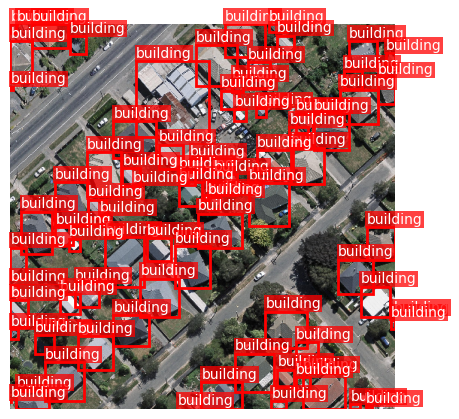

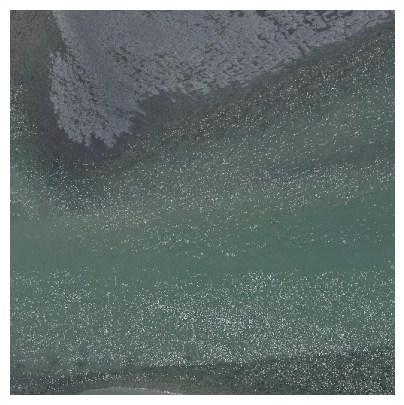

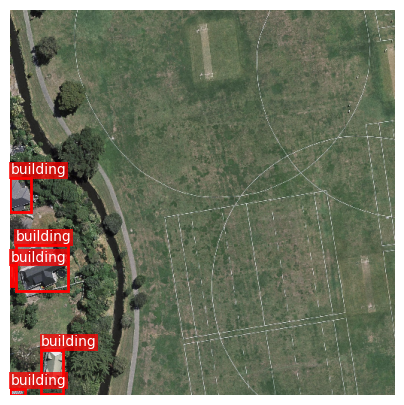

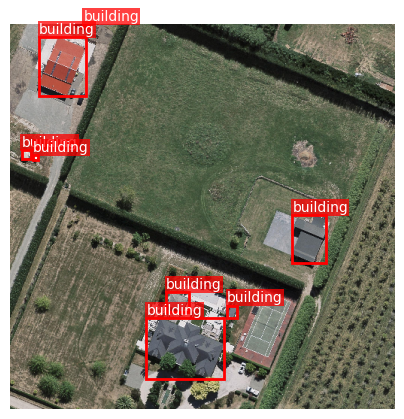

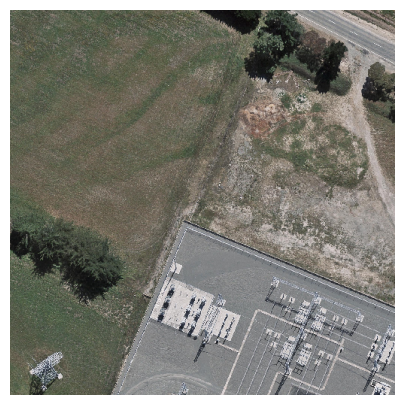

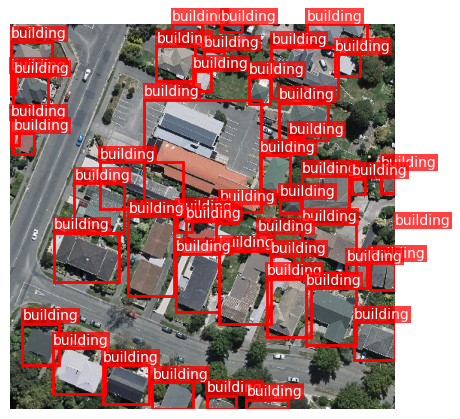

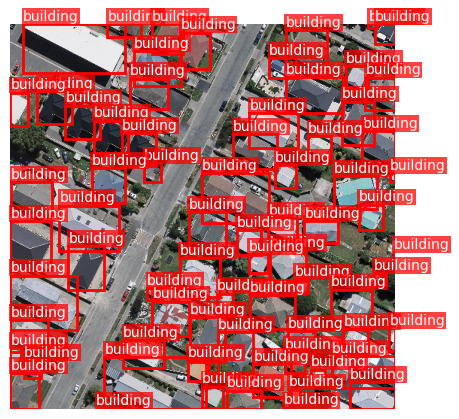

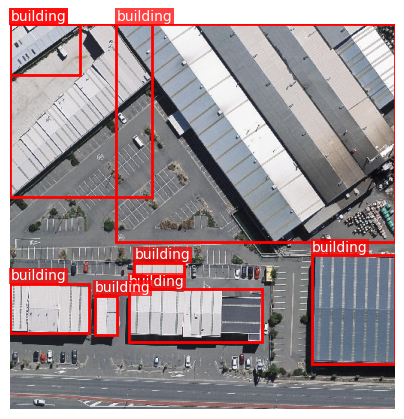

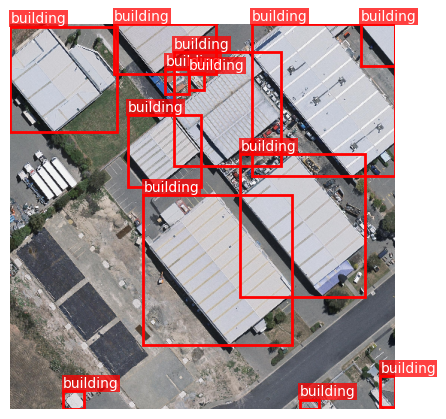

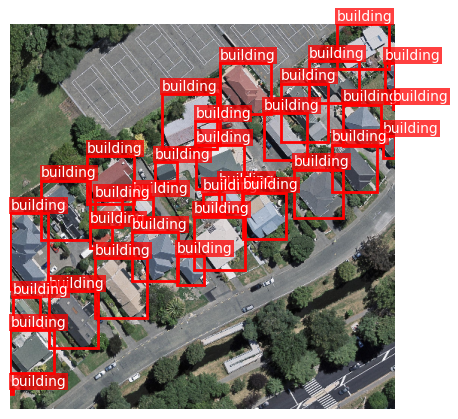

Labels present in the annotations: {'building'}


In [1]:
import json
import os
from pycocotools.coco import COCO
import matplotlib.pyplot as plt
from matplotlib import patches
from PIL import Image

# Path to the annotations file
annotations_path = '/kaggle/input/annotationsfile/annotations_train.json'

# Load the COCO annotations file
with open(annotations_path) as f:
    annotations_data = json.load(f)

# Initialize COCO API for annotations
coco = COCO(annotations_path)

# Load category names
category_dict = {cat['id']: cat['name'] for cat in coco.loadCats(coco.getCatIds())}

# Collect unique labels in the dataset
unique_labels = set()

# Loop through the first 10 images in the dataset
for idx, image_id in enumerate(coco.getImgIds()):
    if idx == 10:
        break  # Stop after displaying 10 images

    image_info = coco.loadImgs(image_id)[0]

    # Load the image
    image_path = os.path.join('/kaggle/input/whu-building-dataset/WHU/train/Image', image_info['file_name'])

    if os.path.exists(image_path):
        image = Image.open(image_path)
    else:
        print(f"Image {image_path} not found.")
        continue
    
    # Display the image
    plt.figure(figsize=(5, 5))
    plt.imshow(image)
    plt.axis('off')

    # Get the annotations for this image
    annotations = coco.loadAnns(coco.getAnnIds(imgIds=[image_id]))

    # Draw bounding boxes and labels
    ax = plt.gca()
    for annotation in annotations:
        bbox = annotation['bbox']
        x, y, width, height = bbox
        category_id = annotation['category_id']
        label = category_dict.get(category_id, "Unknown")  # Get category name
        
        # Add the label to the set
        unique_labels.add(label)

        # Draw bounding box
        rect = patches.Rectangle((x, y), width, height, linewidth=2, edgecolor='r', facecolor='none')
        ax.add_patch(rect)

        # Add label on top of the bounding box
        ax.text(x, y - 5, label, fontsize=10, color='white', bbox=dict(facecolor='red', alpha=0.75, edgecolor='none', pad=1))

    # Show the image with annotations
    plt.show()

# Print all unique labels found in the dataset
print("Labels present in the annotations:", unique_labels)


loading annotations into memory...
Done (t=1.01s)
creating index...
index created!


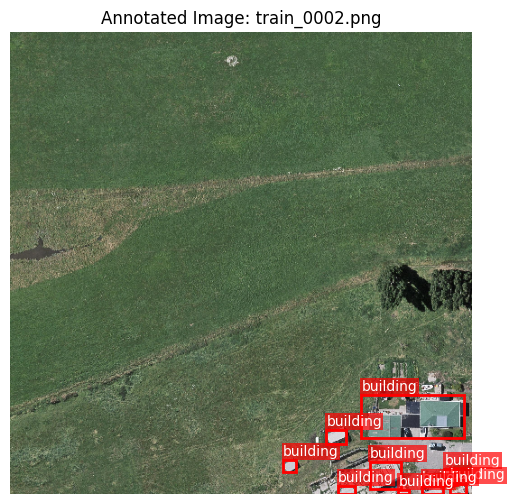

Labels in this image: {'building'}


In [3]:
import json
import os
from pycocotools.coco import COCO
import matplotlib.pyplot as plt
from matplotlib import patches
from PIL import Image

# Set the image file name you want to visualize
image_name = 'train_0002.png'  # <-- Replace this with your image name

# Paths
annotations_path = '/kaggle/input/annotationsfile/annotations_train.json'
image_dir = '/kaggle/input/whu-building-dataset/WHU/train/Image'

# Load COCO annotations
coco = COCO(annotations_path)

# Load category names
category_dict = {cat['id']: cat['name'] for cat in coco.loadCats(coco.getCatIds())}

# Find the image ID using its file name
image_id = None
for img in coco.dataset['images']:
    if img['file_name'] == image_name:
        image_id = img['id']
        image_info = img
        break

if image_id is None:
    print(f"Image {image_name} not found in annotations.")
else:
    image_path = os.path.join(image_dir, image_name)

    if os.path.exists(image_path):
        image = Image.open(image_path)

        plt.figure(figsize=(6, 6))
        plt.imshow(image)
        plt.axis('off')

        # Get annotations for this image
        annotations = coco.loadAnns(coco.getAnnIds(imgIds=[image_id]))

        unique_labels = set()
        ax = plt.gca()

        for annotation in annotations:
            x, y, width, height = annotation['bbox']
            category_id = annotation['category_id']
            label = category_dict.get(category_id, "Unknown")

            unique_labels.add(label)

            rect = patches.Rectangle((x, y), width, height, linewidth=2, edgecolor='red', facecolor='none')
            ax.add_patch(rect)
            ax.text(x, y - 5, label, fontsize=10, color='white',
                    bbox=dict(facecolor='red', alpha=0.7, edgecolor='none', pad=1))

        plt.title(f"Annotated Image: {image_name}")
        plt.show()

        print("Labels in this image:", unique_labels)

    else:
        print(f"Image file not found: {image_path}")
